# BBM444 - Assignment 4: Image Deblurring![U-Net.png](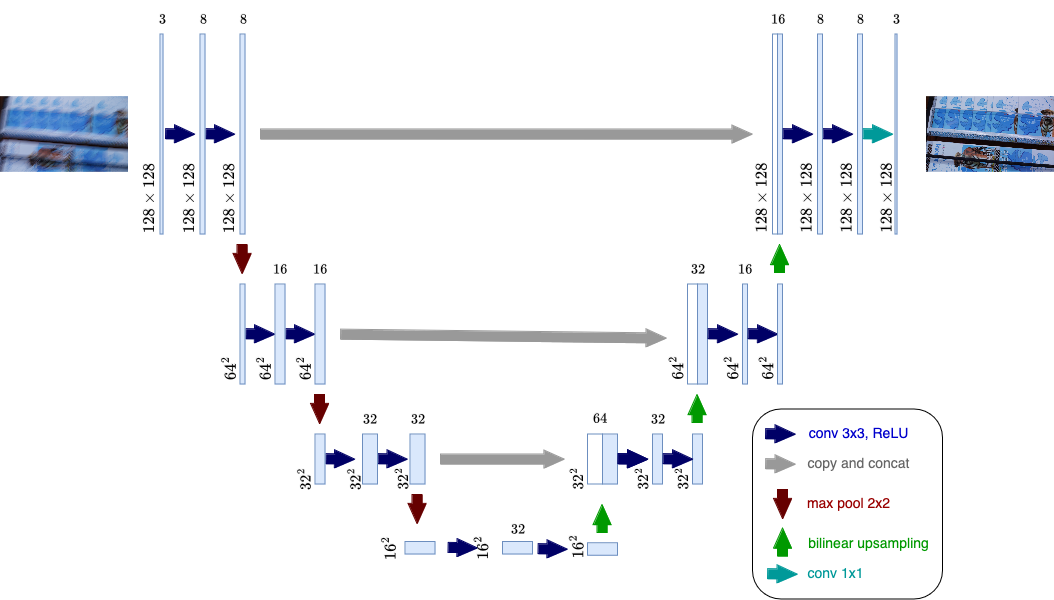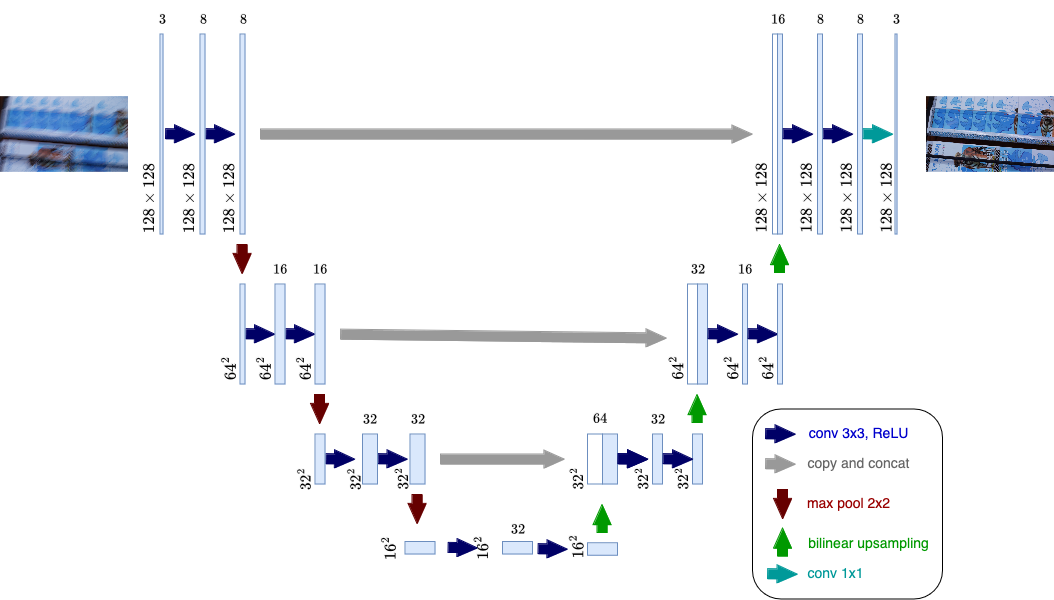)

Bora Dere - 2220765021

## Downloading dataset

You can download the dataset from [link](https://drive.google.com/drive/folders/1XyYsksX99dH3EEdMDHzbo3vqLtIfripN?usp=sharing). Or you can download to the Colab environment by running the cell below. There are two folders in the dataset "train" and "test". The "train" folder includes the images you will use in training. And "test" folder includes images you will use in evaluation only.

In [57]:
# Download the dataset into dataset.zip
!gdown --id 1hMUJnzXoyJZkj8UN9jbpizFwscjBxN19 -O dataset.zip

'gdown' is not recognized as an internal or external command,
operable program or batch file.


In [58]:
# Extract the contents of the file.
!unzip -q dataset.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


## Import Libraries

You can use PyTorch or Tensorflow/Keras(no restrictions).

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split
import torchsummary
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchmetrics.functional import structural_similarity_index_measure as ssim
from torchmetrics.functional import peak_signal_noise_ratio as psnr

import os
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt

We set a manual seed (42) to Python's random, numpy and torch. And also declare some constants that we use in experiments.

In [63]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


DATA_DIR = os.path.join(os.getcwd(), 'data')
TEST_DIR = os.path.join(DATA_DIR, 'test')
TRAIN_DIR = os.path.join(DATA_DIR, 'train')

## Input Preparation

 Develop the RAW into sRGB TIFF format using dcraw command

Since the images created by 2 different dcraw commands will have the same name, thus causing a name collision, I updated the commands a bit. For inputs:

In [61]:
# Get-ChildItem *.dng | ForEach-Object {
#     $base = $_.BaseName
#     dcraw -w -q 3 -o 1 -6 -g 1 1 -T -O "$base`_srgb.tiff" "$($_.Name)"
# }

SyntaxError: invalid syntax (410170287.py, line 1)

And for labels:

In [ ]:
# Get-ChildItem *.dng | ForEach-Object {
#     $base = $_.BaseName
#     dcraw -4 -D -T -O "$base`_raw.tiff" "$($_.Name)"
# }

**Load the dataset**

In the cell below, we load sRGB and RAW images.

In [64]:
def prepare_inputs(dir_path):
    """
    1) Load all *_srgb.tiff in dir_path as float64 [0,1] arrays
    2) Downsample so that the result is at least 256×256 via slicing I[::Nx,::Ny]
    3) Center-crop to exactly 256×256
    4) Add zero-mean Gaussian noise with σ ∈ [0.01,0.02]
    5) Return a torch.float64 tensor of shape (N, 3, 256, 256)
    """
    tensors = []
    for fname in os.listdir(dir_path):
        if not fname.endswith('_srgb.tiff'):
            continue

        img = Image.open(os.path.join(dir_path, fname))
        img_np = np.array(img).astype(np.float64) / 65535.0 

        H, W, C = img_np.shape

        Nx = max(1, H // 256)
        Ny = max(1, W // 256)
        ds = img_np[::Nx, ::Ny, :] 

        h2, w2, _ = ds.shape
        top  = (h2 - 256) // 2
        left = (w2 - 256) // 2
        crop = ds[top:top+256, left:left+256, :]

        sigma = np.random.uniform(0.01, 0.02)
        noise = np.random.normal(0.0, sigma, size=crop.shape)
        noisy = np.clip(crop + noise, 0.0, 1.0)

        tensor = torch.from_numpy(noisy.transpose(2, 0, 1)).to(torch.float64)
        tensors.append(tensor)

    return torch.stack(tensors, dim=0)

In [65]:
X_train = prepare_inputs(TRAIN_DIR)
X_test = prepare_inputs(TEST_DIR)

In [66]:
def prepare_labels(dir_path):
    """
    Loads *_raw.tiff images, linearizes and packs them to shape (4, 128, 128).
    GRBG Bayer pattern used.
    Returns: torch.float64 tensor of shape (N, 4, 128, 128)
    """
    black, white = 64, 1023
    packed_list = []

    for fname in os.listdir(dir_path):
        if not fname.endswith('_raw.tiff'):
            continue
        
        img = Image.open(os.path.join(dir_path, fname))
        raw = np.array(img).astype(np.float64)

        raw = (raw - black) / (white - black)
        np.clip(raw, 0, 1, out=raw)

        G1 = raw[0::2, 1::2] 
        R  = raw[0::2, 0::2] 
        G2 = raw[1::2, 0::2] 
        B  = raw[1::2, 1::2] 

        packed = np.stack([G1, R, G2, B], axis=0)  

        _, H, W = packed.shape
        Nx = max(1, H // 128)
        Ny = max(1, W // 128)
        packed_ds = packed[:, ::Nx, ::Ny]

        _, h2, w2 = packed_ds.shape
        top  = (h2 - 128) // 2
        left = (w2 - 128) // 2
        cropped = packed_ds[:, top:top+128, left:left+128]

        packed_tensor = torch.from_numpy(cropped).to(torch.float64)
        packed_list.append(packed_tensor)

    return torch.stack(packed_list, dim=0)

In [67]:
y_train = prepare_labels(TRAIN_DIR)
y_test = prepare_labels(TEST_DIR)

In [68]:
# Split the dataset into train and test
# what? it's already split?



#######################
print(f"Shape of train samples: {X_train[0].shape}")
print(f"Shape of ground-truth image: {y_train[0].shape}")
print(f"{len(X_train)} samples in train\n{len(X_test)} samples in test")

Shape of train samples: torch.Size([3, 256, 256])
Shape of ground-truth image: torch.Size([4, 128, 128])
130 samples in train
45 samples in test


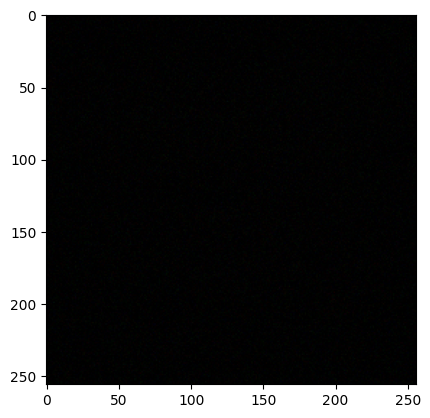

In [69]:
# Display a random image from the dataset
plt.imshow(X_train[0].permute(1, 2, 0).numpy())

**Downsampling**

In [ ]:
# order of run in this notebook is a bit odd to me, that's why these cells are empty and the image above is redundant

**Noise augmentation**

In [ ]:
# :)

## Label Preparation

## Data Split

Merge the inputs and labels to create the dataset. Then, split them into patches into 90 % train, 10 % validation

In [70]:
# STEP 1: Normalize full X_train before splitting
mean = X_train.mean(dim=(0, 2, 3))
std  = X_train.std(dim=(0, 2, 3))

print(f"Mean of the train set is: {mean}")
print(f"Standard deviation of the train set is: {std}")

def normalize_tensor_batch(batch, mean, std):
    return (batch - mean.view(3, 1, 1)) / std.view(3, 1, 1)

X_train_norm = normalize_tensor_batch(X_train, mean, std)
X_test_norm  = normalize_tensor_batch(X_test, mean, std)

# STEP 2: Now split the normalized tensors
num_total = X_train_norm.shape[0]
num_val = int(0.1 * num_total)
num_train = num_total - num_val

X_train_split, X_val = random_split(X_train_norm, [num_train, num_val], generator=torch.Generator().manual_seed(42))
y_train_split, y_val = random_split(y_train, [num_train, num_val], generator=torch.Generator().manual_seed(42))

# STEP 3: Extract tensors from subsets using indices
train_indices = X_train_split.indices
val_indices = X_val.indices

X_train_final = X_train_norm[train_indices]
Y_train_final = y_train[train_indices]

X_val_final = X_train_norm[val_indices]
Y_val_final = y_train[val_indices]

Mean of the train set is: tensor([0.0063, 0.0063, 0.0062], dtype=torch.float64)
Standard deviation of the train set is: tensor([0.0091, 0.0091, 0.0090], dtype=torch.float64)


# **Model Architecture & Training**

## Stage I: sRGB → 4-Plane RAW

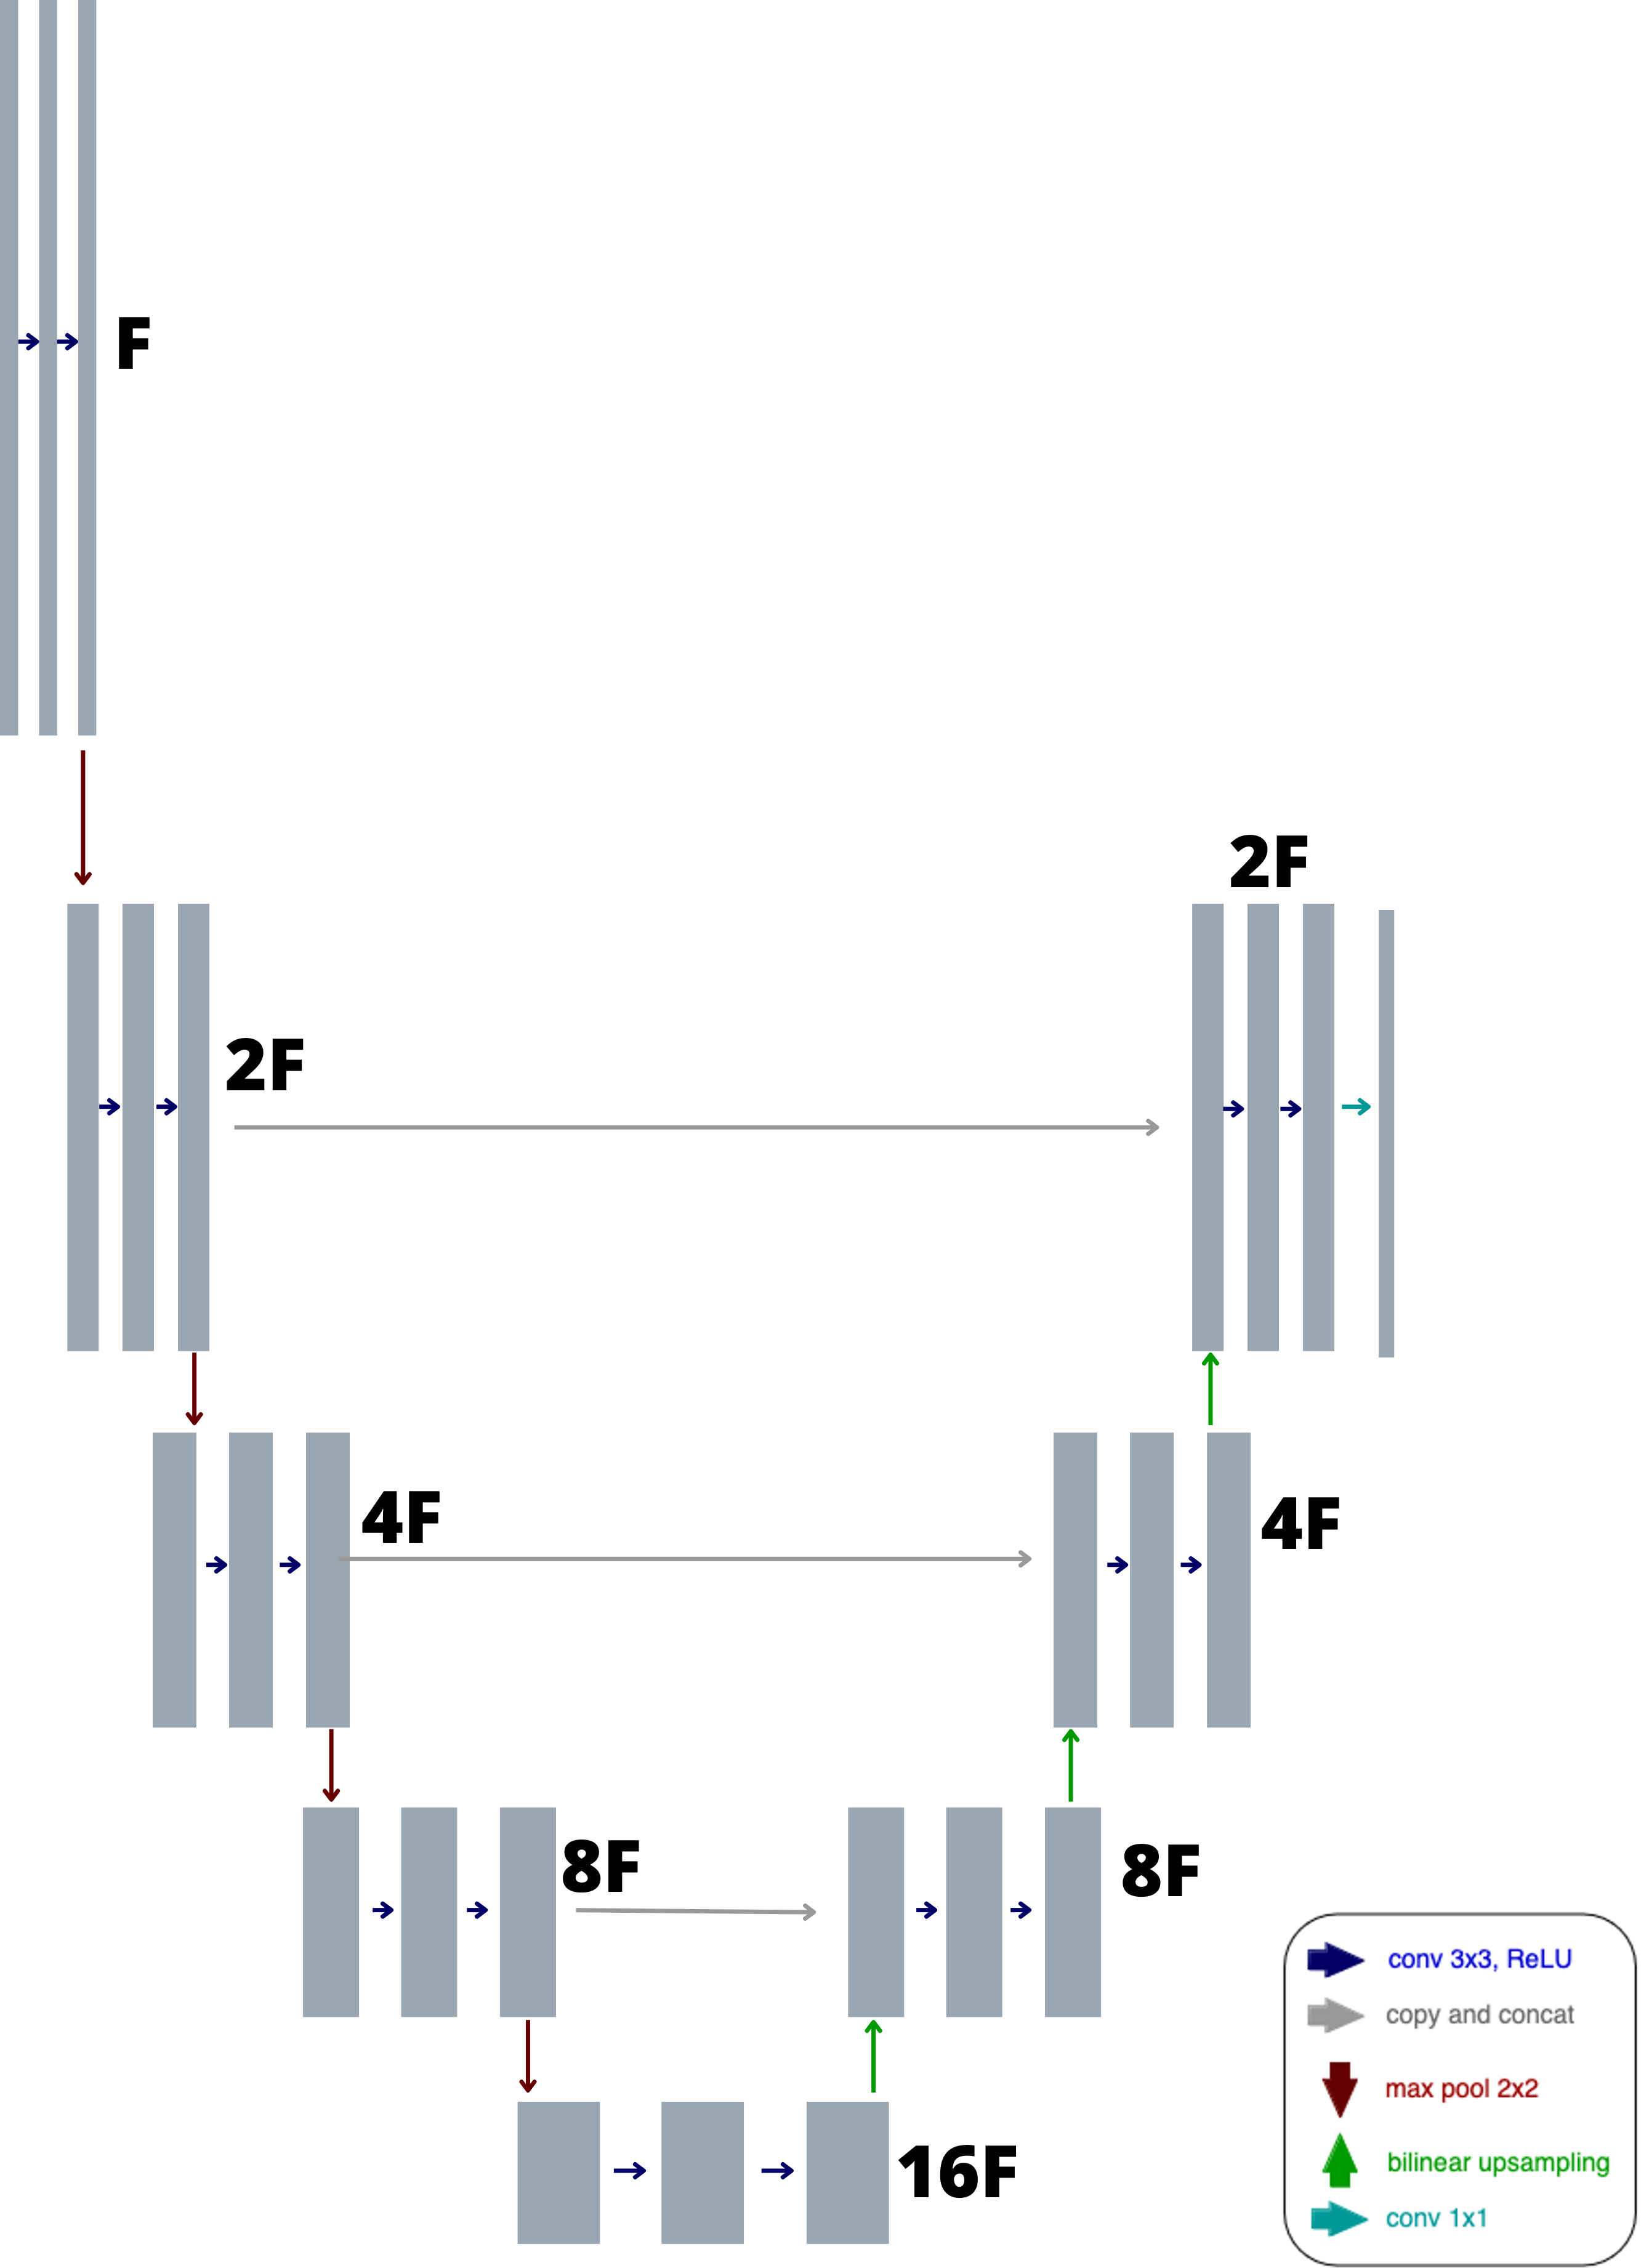

**Note:** The cells below are designed to guide you to build the your modified UNET. But you are not required to follow the structure below.

In [137]:
class DoubleConv(nn.Module):
    """(Conv3x3 + ReLU) × 2"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=4, base_filters=8):
        super().__init__()
        F = base_filters

        # Encoder
        self.enc1 = DoubleConv(in_channels, F)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = DoubleConv(F, 2*F)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = DoubleConv(2*F, 4*F)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = DoubleConv(4*F, 8*F)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(8*F, 16*F)

        # Decoder
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec3 = DoubleConv(16*F + 8*F, 8*F)

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec2 = DoubleConv(8*F + 4*F, 4*F)

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = DoubleConv(4*F + 2*F, 2*F)

        self.final_conv = nn.Conv2d(2*F, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        # Bottleneck
        b = self.bottleneck(self.pool4(e4))

        # Decoder
        d3 = self.up3(b)
        d3 = torch.cat([d3, e4], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e3], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec1(d1)

        return self.final_conv(d1)

In [138]:
unet = UNet()

input_size= (3, 256, 256)
torchsummary.summary(unet.cuda(), input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 256, 256]             224
              ReLU-2          [-1, 8, 256, 256]               0
            Conv2d-3          [-1, 8, 256, 256]             584
              ReLU-4          [-1, 8, 256, 256]               0
        DoubleConv-5          [-1, 8, 256, 256]               0
         MaxPool2d-6          [-1, 8, 128, 128]               0
            Conv2d-7         [-1, 16, 128, 128]           1,168
              ReLU-8         [-1, 16, 128, 128]               0
            Conv2d-9         [-1, 16, 128, 128]           2,320
             ReLU-10         [-1, 16, 128, 128]               0
       DoubleConv-11         [-1, 16, 128, 128]               0
        MaxPool2d-12           [-1, 16, 64, 64]               0
           Conv2d-13           [-1, 32, 64, 64]           4,640
             ReLU-14           [-1, 32,

### Train the network

In [96]:
batch_size = 8
epochs = 50
lr = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [97]:
train_dataset = TensorDataset(X_train_final, Y_train_final)
val_dataset   = TensorDataset(X_val_final, Y_val_final)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size)

model = UNet(in_channels=3, out_channels=4).to(device).double()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

In [160]:
Y_train_final.shape

torch.Size([117, 4, 128, 128])

In [98]:
best_val_loss = float('inf')

for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        if torch.rand(1) < 0.5:
            x = torch.flip(x, dims=[-1])  
            y = torch.flip(y, dims=[-1])
        if torch.rand(1) < 0.5:
            x = torch.flip(x, dims=[-2])  
            y = torch.flip(y, dims=[-2])
        if torch.rand(1) < 0.5:
            k = torch.randint(1, 4, (1,)).item()
            x = torch.rot90(x, k, dims=[-2, -1])
            y = torch.rot90(y, k, dims=[-2, -1])
        if torch.rand(1) < 0.5:
            exposure = torch.rand(1).item() * 0.6 - 0.3
            x = torch.clamp(x * (2 ** exposure), 0, 1)

        optimizer.zero_grad()
        pred = model(x)

        l1_loss = nn.functional.l1_loss(pred, y)
        ssim_loss = 1 - ssim(pred, y, data_range=1.0)
        loss = 0.8 * l1_loss + 0.2 * ssim_loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            l1 = nn.functional.l1_loss(pred, y)
            ssim_val = 1 - ssim(pred, y, data_range=1.0)
            loss = 0.8 * l1 + 0.2 * ssim_val
            val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f"Epoch {epoch:02d} | Train Loss: {running_loss/len(train_loader):.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_stage1.pth')

    scheduler.step()

c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\torchmetrics\utilities\prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


Epoch 01 | Train Loss: 0.2394 | Val Loss: 0.2445
Epoch 02 | Train Loss: 0.2279 | Val Loss: 0.2322
Epoch 03 | Train Loss: 0.2154 | Val Loss: 0.2206
Epoch 04 | Train Loss: 0.2091 | Val Loss: 0.2148
Epoch 05 | Train Loss: 0.2066 | Val Loss: 0.2115
Epoch 06 | Train Loss: 0.2042 | Val Loss: 0.2089
Epoch 07 | Train Loss: 0.2024 | Val Loss: 0.2072
Epoch 08 | Train Loss: 0.2007 | Val Loss: 0.2064
Epoch 09 | Train Loss: 0.1975 | Val Loss: 0.2013
Epoch 10 | Train Loss: 0.1861 | Val Loss: 0.1693
Epoch 11 | Train Loss: 0.1606 | Val Loss: 0.1659
Epoch 12 | Train Loss: 0.1510 | Val Loss: 0.1588
Epoch 13 | Train Loss: 0.1460 | Val Loss: 0.1562
Epoch 14 | Train Loss: 0.1439 | Val Loss: 0.1550
Epoch 15 | Train Loss: 0.1425 | Val Loss: 0.1543
Epoch 16 | Train Loss: 0.1411 | Val Loss: 0.1532
Epoch 17 | Train Loss: 0.1405 | Val Loss: 0.1520
Epoch 18 | Train Loss: 0.1391 | Val Loss: 0.1513
Epoch 19 | Train Loss: 0.1385 | Val Loss: 0.1507
Epoch 20 | Train Loss: 0.1383 | Val Loss: 0.1512
Epoch 21 | Train Los

### Testing

In [102]:
model.load_state_dict(torch.load('best_model_stage1.pth'))
model.eval()

psnr_total = 0.0
ssim_total = 0.0
noise_ratio_total = 0.0

X_test_norm = X_test_norm.to(device)
y_test = y_test.to(device)

with torch.no_grad():
    for i in range(X_test_norm.shape[0]):
        x = X_test_norm[i].unsqueeze(0).to(device)  # shape: (1, 3, 256, 256)
        y = y_test[i].unsqueeze(0).to(device)        # shape: (1, 4, 128, 128)

        pred = model(x)

        # --- PSNR ---
        psnr_val = psnr(pred, y, data_range=1.0)
        psnr_total += psnr_val.item()

        # --- SSIM ---
        ssim_val = ssim(pred, y, data_range=1.0)
        ssim_total += ssim_val.item()

        # --- Noise Ratio ---
        diff = torch.norm(pred - y)
        ref  = torch.norm(y)
        noise_ratio = diff / ref
        noise_ratio_total += noise_ratio.item()

# Compute averages
n = X_test_norm.shape[0]
avg_psnr = psnr_total / n
avg_ssim = ssim_total / n
avg_noise_ratio = noise_ratio_total / n

print(f"\nTest Results:")
print(f"  PSNR          : {avg_psnr:.2f} dB")
print(f"  SSIM          : {avg_ssim:.4f}")
print(f"  Noise Ratio   : {avg_noise_ratio:.4f}")

C:\Users\Bora\AppData\Local\Temp\ipykernel_64360\4145339261.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_stage1.pth'))
c:


Test Results:
  PSNR          : 28.37 dB
  SSIM          : 0.5539
  Noise Ratio   : 1.0662


###  Stage II: sRGB → Single-Channel Full-Res Bayer

### Update the Labels, so the dataset

In [106]:
def prepare_bayer_labels(dir_path):
    """
    Loads *_raw.tiff images, linearizes them and returns full-resolution Bayer mosaic.
    Returns: torch.float64 tensor of shape (N, 1, 256, 256)
    """
    black, white = 64, 1023
    bayer_list = []
    for fname in os.listdir(dir_path):
        if not fname.endswith('_raw.tiff'):
            continue
        
        img = Image.open(os.path.join(dir_path, fname))
        raw = np.array(img).astype(np.float64)

        # Linearize
        raw = (raw - black) / (white - black)
        np.clip(raw, 0, 1, out=raw)
        
        # Downsample to 256x256 (same as sRGB input)
        H, W = raw.shape
        Nx = max(1, H // 256)
        Ny = max(1, W // 256)
        raw_ds = raw[::Nx, ::Ny]

        # Center crop to exactly 256x256
        h2, w2 = raw_ds.shape
        top = (h2 - 256) // 2
        left = (w2 - 256) // 2
        cropped = raw_ds[top:top+256, left:left+256]
        
        # Add channel dimension
        tensor = torch.from_numpy(cropped).unsqueeze(0).to(torch.float64)
        bayer_list.append(tensor)

    return torch.stack(bayer_list, dim=0)

# Prepare full-resolution Bayer mosaics
y_train_bayer = prepare_bayer_labels(TRAIN_DIR)
y_test_bayer = prepare_bayer_labels(TEST_DIR)

# Split the data for Stage 2
train_indices = X_train_split.indices
val_indices = X_val.indices

X_train_final_s2 = X_train_norm[train_indices]
y_train_final_s2 = y_train_bayer[train_indices]

X_val_final_s2 = X_train_norm[val_indices]
y_val_final_s2 = y_train_bayer[val_indices]

# Create datasets and dataloaders for Stage 2
train_dataset_s2 = TensorDataset(X_train_final_s2, y_train_final_s2)
val_dataset_s2 = TensorDataset(X_val_final_s2, y_val_final_s2)

train_loader_s2 = DataLoader(train_dataset_s2, batch_size=batch_size, shuffle=True)
val_loader_s2 = DataLoader(val_dataset_s2, batch_size=batch_size)

### Update the model

In [186]:
class UNetStage2(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, base_filters=8):
        super().__init__()
        F = base_filters
        
        # Encoder - same as stage 1
        self.enc1 = DoubleConv(in_channels, F)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = DoubleConv(F, 2*F)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = DoubleConv(2*F, 4*F)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = DoubleConv(4*F, 8*F)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck - same as stage 1
        self.bottleneck = DoubleConv(8*F, 16*F)

        # Decoder - same as stage 1 for the first three blocks
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec3 = DoubleConv(16*F + 8*F, 8*F)

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec2 = DoubleConv(8*F + 4*F, 4*F)

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = DoubleConv(4*F + 2*F, 2*F)

        # Additional upsampling block for Stage 2
        self.up0 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec0 = DoubleConv(2*F + F, F)
        
        # Moved final conv to operate on the new decoder block
        self.final_conv = nn.Conv2d(F, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        # Bottleneck
        b = self.bottleneck(self.pool4(e4))

        # Decoder
        d3 = self.up3(b)
        d3 = torch.cat([d3, e4], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e3], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec1(d1)
        
        # Extra upsampling block with skip connection from encoder's first layer
        d0 = self.up0(d1)
        d0 = torch.cat([d0, e1], dim=1)
        d0 = self.dec0(d0)
    
        return self.final_conv(d0)

ok there is somehting wrong. see i think my model for the second stage should predict 256x256, because my model for the first stage predicts: [-1, 4, 128, 128]

which is R^(4 x H/2 x W/2) 4-plane pack.

but now the second stage should predict R^(1 x H x W)

so i believe the shape should be 256x256. but also, considering this model was correct for the first stage:

class DoubleConv(nn.Module):
    """(Conv3x3 + ReLU) × 2"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=4, base_filters=8):
        super().__init__()
        F = base_filters

        # Encoder
        self.enc1 = DoubleConv(in_channels, F)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = DoubleConv(F, 2*F)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = DoubleConv(2*F, 4*F)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = DoubleConv(4*F, 8*F)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(8*F, 16*F)

        # Decoder
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec3 = DoubleConv(16*F + 8*F, 8*F)

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec2 = DoubleConv(8*F + 4*F, 4*F)

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = DoubleConv(4*F + 2*F, 2*F)

        self.final_conv = nn.Conv2d(2*F, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        # Bottleneck
        b = self.bottleneck(self.pool4(e4))

        # Decoder
        d3 = self.up3(b)
        d3 = torch.cat([d3, e4], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e3], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec1(d1)

        return self.final_conv(d1)

this is what given as the architecture tweaks:

Architecture tweak: Remove the last 2×2 max-pool in the encoder and add one extra
up-conv + 3×3 conv block in the decoder so the final output is 1 ×H ×W.

so i believe the last up-conv is necessary. maybe the last extra block should have only 1 conv instead of doubleconv? i dont know. just assuming the stage 1 model implementation is correct, and stage 2 architecture tweaks are given correct, apply those tweaks and code the model for the second stage. write down the shape for each step and reason your way through it to ensure there is nothing wrong

In [187]:
def transfer_weights_stage1_to_stage2(model_s1, model_s2):
    """Transfer compatible weights from Stage 1 model to Stage 2"""
    s1_state_dict = model_s1.state_dict()
    s2_state_dict = model_s2.state_dict()
    
    # Copy all matching layers
    for name, param in s1_state_dict.items():
        if name in s2_state_dict and s2_state_dict[name].shape == param.shape:
            s2_state_dict[name].copy_(param)
    
    # Note: Final layer weights won't be copied due to different shapes
    return model_s2

# Create Stage 1 model and load its weights
model_s1 = UNet(in_channels=3, out_channels=4).to(device).double()
model_s1.load_state_dict(torch.load('best_model_stage1.pth'))

# Create Stage 2 model and transfer weights
model_s2 = UNetStage2(in_channels=3, out_channels=1).to(device).double()
model_s2 = transfer_weights_stage1_to_stage2(model_s1, model_s2)

C:\Users\Bora\AppData\Local\Temp\ipykernel_64360\3106051616.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_s1.load_state_dict(torch.load('best_model_stage1.pth')

### Train the network

In [188]:
# Initialize optimizer and scheduler for Stage 2
optimizer_s2 = optim.Adam(model_s2.parameters(), lr=lr)
scheduler_s2 = CosineAnnealingLR(optimizer_s2, T_max=epochs)

# Training loop for Stage 2
best_val_loss_s2 = float('inf')

for epoch in range(1, epochs + 1):
    model_s2.train()
    running_loss = 0.0
    
    for x, mosaic in train_loader_s2:
        x, mosaic = x.to(device), mosaic.to(device)

        # Apply the same augmentations as in Stage 1
        if torch.rand(1) < 0.5:
            x = torch.flip(x, dims=[-1])  
            mosaic = torch.flip(mosaic, dims=[-1])
        if torch.rand(1) < 0.5:
            x = torch.flip(x, dims=[-2])  
            mosaic = torch.flip(mosaic, dims=[-2])
        if torch.rand(1) < 0.5:
            k = torch.randint(1, 4, (1,)).item()
            x = torch.rot90(x, k, dims=[-2, -1])
            mosaic = torch.rot90(mosaic, k, dims=[-2, -1])
        if torch.rand(1) < 0.5:
            exposure = torch.rand(1).item() * 0.6 - 0.3
            x = torch.clamp(x * (2 ** exposure), 0, 1)

        optimizer_s2.zero_grad()
        pred = model_s2(x)

        l1_loss = nn.functional.l1_loss(pred, mosaic)
        ssim_loss = 1 - ssim(pred, mosaic, data_range=1.0)
        loss = 0.8 * l1_loss + 0.2 * ssim_loss

        loss.backward()
        optimizer_s2.step()

        running_loss += loss.item()
    
    # Validation
    model_s2.eval()
    val_loss = 0.0
    val_psnr = 0.0
    val_ssim_score = 0.0
    
    with torch.no_grad():
        for x, mosaic in val_loader_s2:
            x, mosaic = x.to(device), mosaic.to(device)
            pred = model_s2(x)
            
            # Calculate losses
            l1 = nn.functional.l1_loss(pred, mosaic)
            ssim_val = 1 - ssim(pred, mosaic, data_range=1.0)
            loss = 0.8 * l1 + 0.2 * ssim_val
            val_loss += loss.item()
            
            # Calculate metrics
            val_psnr += psnr(pred, mosaic, data_range=1.0).item()
            val_ssim_score += ssim(pred, mosaic, data_range=1.0).item()
    
    val_loss /= len(val_loader_s2)
    val_psnr /= len(val_loader_s2)
    val_ssim_score /= len(val_loader_s2)
    
    print(f"Epoch {epoch:02d} | Train Loss: {running_loss/len(train_loader_s2):.4f} | "
          f"Val Loss: {val_loss:.4f} | Val PSNR: {val_psnr:.2f} | Val SSIM: {val_ssim_score:.4f}")

    if val_loss < best_val_loss_s2:
        best_val_loss_s2 = val_loss
        torch.save(model_s2.state_dict(), 'best_model_stage2.pth')

    scheduler_s2.step()

Epoch 01 | Train Loss: 0.3921 | Val Loss: 0.3780 | Val PSNR: 14.78 | Val SSIM: -0.3400
Epoch 02 | Train Loss: 0.3826 | Val Loss: 0.3676 | Val PSNR: 15.49 | Val SSIM: -0.3665
Epoch 03 | Train Loss: 0.2966 | Val Loss: 0.1848 | Val PSNR: 18.44 | Val SSIM: 0.3468


KeyboardInterrupt: 

### Report Results

### Visualisation

### Discussion

###  Bonus — Forward ISP Rendering